In [41]:
import pandas as pd
import numpy as np
import quantstats as qs
import warnings
import itertools # Needed for generating combinations
from tqdm.auto import tqdm # Optional: for progress bar

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# --- Functions from Script 1 (or adapted for Script 2) ---

def load_data(cb_path, index_path):
    """Loads convertible bond and index data. (Adapted from Script 1)"""
    print("--- Step 1: Loading Data ---")
    try:
        df = pd.read_parquet(cb_path)
        index_df = pd.read_parquet(index_path)

        # Clean index_df
        if not isinstance(index_df.index, pd.DatetimeIndex):
            index_df.index = pd.to_datetime(index_df.index)
        index_df.index = index_df.index.dropna() # Remove NaT
        if not index_df.index.is_unique:
            index_df = index_df[~index_df.index.duplicated(keep='first')]
        index_df = index_df.sort_index()
        index_df.index = index_df.index.normalize()
        print("Index DataFrame index cleaned, sorted, and normalized.")

        # Clean df (CB data)
        if 'trade_date' in df.index.names:
            date_level_idx = df.index.names.index('trade_date')
            if not isinstance(df.index.levels[date_level_idx], pd.DatetimeIndex):
                df.index = df.index.set_levels(pd.to_datetime(df.index.levels[date_level_idx]), level='trade_date')
        else:
             required_levels = ['code', 'trade_date']
             if all(col in df.columns for col in required_levels):
                 df['trade_date'] = pd.to_datetime(df['trade_date'])
                 df = df.set_index(required_levels)
             else:
                 raise ValueError("Cannot set multi-index for CB data, 'code' or 'trade_date' columns missing or not in index.")
        
        # Ensure trade_date level in CB data is DatetimeIndex
        if 'trade_date' in df.index.names:
            trade_date_level_values = df.index.get_level_values('trade_date')
            if not isinstance(trade_date_level_values, pd.DatetimeIndex):
                 df.index = df.index.set_levels(pd.to_datetime(trade_date_level_values), level='trade_date')


        print(f"Loaded CB data shape: {df.shape}, Index data shape: {index_df.shape}")
        return df, index_df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None, None

def filter_data(df_raw, start_date, end_date, custom_filter_rules): # Renamed strategy_filter_rules
    """Applies date range and strategy-specific custom filters. (Adapted from Script 1)"""
    print(f"--- Filtering Data (Initial Custom Filters: {custom_filter_rules}) ---")
    if df_raw is None:
        print("  Error: Raw DataFrame is None.")
        return None
    
    try:
        df_temp_filtered = df_raw.copy()
        # Ensure 'trade_date' is a DatetimeIndex for filtering
        if 'trade_date' not in df_temp_filtered.index.names:
            if 'trade_date' in df_temp_filtered.columns:
                df_temp_filtered['trade_date'] = pd.to_datetime(df_temp_filtered['trade_date'])
                if 'code' in df_temp_filtered.columns and 'code' not in df_temp_filtered.index.names:
                    df_temp_filtered = df_temp_filtered.set_index(['trade_date', 'code'])
                elif 'code' in df_temp_filtered.index.names and 'trade_date' not in df_temp_filtered.index.names:
                    df_temp_filtered = df_temp_filtered.set_index('trade_date', append=True).reorder_levels(['trade_date', 'code']) # Ensure order
                elif 'trade_date' not in df_temp_filtered.index.names :
                    df_temp_filtered = df_temp_filtered.set_index('trade_date') # If only trade_date
            else:
                print("  Error: 'trade_date' column not found for date filtering.")
                return None
        
        if 'trade_date' in df_temp_filtered.index.names:
            trade_date_level = df_temp_filtered.index.get_level_values('trade_date')
            if not isinstance(trade_date_level, pd.DatetimeIndex):
                 df_temp_filtered.index = df_temp_filtered.index.set_levels(pd.to_datetime(trade_date_level), level='trade_date')
                 trade_date_level = df_temp_filtered.index.get_level_values('trade_date')
            date_mask = (trade_date_level >= start_date) & (trade_date_level <= end_date)
        else: # Should not happen if load_data and above logic works
            print("  Fatal Error: 'trade_date' not in index for date filtering after attempts.")
            return None

        df_filtered = df_temp_filtered[date_mask].copy()

        if df_filtered.empty:
            print(f"  Warning: No data remaining after date filtering ({start_date} to {end_date}). Shape: {df_filtered.shape}")
            return None
        print(f"  Filtered by date: {start_date} to {end_date}. Shape: {df_filtered.shape}")

    except Exception as e:
        print(f"  Error during date filtering or initial index setup: {e}")
        return None

    df_filtered['filter_out'] = False
    print(f"  Initial eligible bond-days (before any filters): {len(df_filtered[~df_filtered['filter_out']])}")
    print("  Applying essential filters...")
    redeem_statuses = ['已公告强赎', '公告到期赎回', '公告实施强赎', '公告提示强赎', '已满足强赎条件']
    if 'is_call' in df_filtered.columns:
        df_filtered.loc[df_filtered['is_call'].isin(redeem_statuses), 'filter_out'] = True
        print(f"    After 'is_call' filter: {len(df_filtered[~df_filtered['filter_out']])} eligible bond-days remaining.")
    else: print("    'is_call' column not found, skipping this essential filter.")

    if 'list_days' in df_filtered.columns:
        df_filtered.loc[df_filtered['list_days'] <= 3, 'filter_out'] = True
        print(f"    After 'list_days <= 3' filter: {len(df_filtered[~df_filtered['filter_out']])} eligible bond-days remaining.")
    else: print("    'list_days' column not found, skipping this essential filter.")

    # # --- NEW FILTER: Exclude ST Stocks ---
    # if 'name_stk' in df_filtered.columns:
    #     # Ensure 'name_stk' is string type and handle potential NaNs by filling with empty string
    #     # The .str accessor works on Series of strings.
    #     st_mask = df_filtered['name_stk'].fillna('').str.contains('ST|st', case=True, regex=True)
    #     df_filtered.loc[st_mask, 'filter_out'] = True
    #     print(f"    After 'name_stk' (ST/st) filter: {len(df_filtered[~df_filtered['filter_out']])} eligible bond-days remaining.")
    # else:
    #     print("    'name_stk' column not found, skipping ST stock filter.")


    
    print("  Applying custom filters...")
    if custom_filter_rules:
        for i, rule in enumerate(custom_filter_rules):
            if df_filtered[~df_filtered['filter_out']].empty:
                print(f"    Skipping remaining custom filters as no eligible data points left before rule '{rule}'.")
                break
            try:
                # df_filtered.query(rule) operates on rows where filter_out is False implicitly if not careful.
                # We want to identify bonds to filter out from the *currently eligible* set based on the rule.
                # The rule itself should define what to *exclude*.
                # So, if a rule `close < 102` means "exclude bonds with close < 102",
                # we find those and mark them `filter_out = True`.
                
                # Query on the whole df_filtered, then mark those matching indices as filter_out = True
                indices_matching_rule_in_full_df = df_filtered.query(rule).index
                df_filtered.loc[indices_matching_rule_in_full_df, 'filter_out'] = True
                print(f"    After custom filter rule [{i+1}] '{rule}': {len(df_filtered[~df_filtered['filter_out']])} eligible bond-days remaining.")
            except Exception as e:
                print(f"    - Warning: Could not apply filter rule '{rule}'. Error: {e}. Eligible count remains {len(df_filtered[~df_filtered['filter_out']])}.")
    else:
        print("    No custom filter rules provided.")
    
    final_eligible_count = len(df_filtered[~df_filtered['filter_out']])
    print(f"  Filtering complete. Final eligible bond-days: {final_eligible_count}")
    if final_eligible_count == 0:
        print("  Warning: No bonds eligible after applying all filters.")
    return df_filtered

def calculate_scores(df, factor_weights):
    """Ranks factors, calculates weighted score. (Adapted from Script 1/2)"""
    if df is None or 'filter_out' not in df.columns: return None
    df_eligible = df[~df['filter_out']].copy() # Work on a copy of eligible rows
    
    if df_eligible.empty:
        # If no eligible bonds, return original df with NaN scores/ranks
        df_scored_final = df.copy()
        df_scored_final['final_score'] = np.nan
        df_scored_final['final_rank'] = np.nan
        for factor in factor_weights.keys(): df_scored_final[f"{factor}_rank"] = np.nan
        return df_scored_final

    # If there are eligible bonds, proceed with scoring them
    df_scored_eligible = df_eligible.copy() # Scores are calculated on eligible portion
    df_scored_eligible['final_score'] = 0.0
    factors_used = list(factor_weights.keys())

    for factor in factors_used:
        if factor not in df_scored_eligible.columns:
            print(f"Warning: Factor '{factor}' not found in DataFrame columns. Skipping this factor.")
            df_scored_eligible[f"{factor}_rank"] = np.nan
            continue
        weight = factor_weights[factor]
        rank_col_name = f"{factor}_rank"
        df_scored_eligible[factor] = pd.to_numeric(df_scored_eligible[factor], errors='coerce')
        
        # Group by trade_date (level or column)
        if 'trade_date' in df_scored_eligible.index.names:
            ranks = df_scored_eligible.groupby(level='trade_date')[factor].rank(method='first', ascending=False)
        elif 'trade_date' in df_scored_eligible.columns: # Should not happen if indexing is correct
            ranks = df_scored_eligible.groupby('trade_date')[factor].rank(method='first', ascending=False)
        else:
            print(f"Error: 'trade_date' not found in index or columns for ranking factor {factor}.")
            df_scored_eligible[rank_col_name] = np.nan
            continue
            
        df_scored_eligible[rank_col_name] = ranks
        df_scored_eligible['final_score'] += df_scored_eligible[rank_col_name].fillna(0) * weight # fillna(0) for ranks

    # Rank final_score on eligible data
    if 'trade_date' in df_scored_eligible.index.names:
        df_scored_eligible['final_rank'] = df_scored_eligible.groupby(level='trade_date')['final_score'].rank(method='first', ascending=True, na_option='bottom')
    elif 'trade_date' in df_scored_eligible.columns:
        df_scored_eligible['final_rank'] = df_scored_eligible.groupby('trade_date')['final_score'].rank(method='first', ascending=True, na_option='bottom')
    else:
        df_scored_eligible['final_rank'] = np.nan


    # Merge scores back into the original df structure
    df_scored_final = df.copy()
    # Initialize columns in the full dataframe
    df_scored_final['final_score'] = np.nan
    df_scored_final['final_rank'] = np.nan
    for factor in factors_used: df_scored_final[f"{factor}_rank"] = np.nan
    
    # Update with calculated scores for eligible rows
    df_scored_final.update(df_scored_eligible[['final_score', 'final_rank'] + [f"{f}_rank" for f in factors_used if f"{f}_rank" in df_scored_eligible.columns]])
    
    # Explicitly set NaN for filtered out rows (already done by init, but good for clarity)
    df_scored_final.loc[df_scored_final['filter_out'], ['final_score', 'final_rank']] = np.nan
    # Also set factor ranks to NaN for filtered_out items
    for factor in factors_used:
        if f"{factor}_rank" in df_scored_final.columns:
             df_scored_final.loc[df_scored_final['filter_out'], f"{factor}_rank"] = np.nan
             
    return df_scored_final

def apply_dynamic_rules_for_search(df_scored, config_params):
    """Applies dynamic SP/SL rules based on CONFIG. (Adapted from Script 1)"""
    df_out = df_scored.copy()
    
    # Dynamic Stop-Profit
    dynamic_sp_config = config_params.get('dynamic_stop_profit', {'enabled': False})
    default_sp_pct = config_params.get('stop_profit_pct', 0.03) # Fallback static from main config

    if dynamic_sp_config.get('enabled', False) and 'close' in df_out.columns:
        base_factor_sp = dynamic_sp_config.get('base_factor', default_sp_pct)
        # This specific formula `base_factor * (close / 150)` was in Script 2's loop.
        # We replicate it here if 'dynamic_stop_profit' is enabled.
        # Add min/max from config if they exist, like in Script 1
        min_sp = dynamic_sp_config.get('min_pct')
        max_sp = dynamic_sp_config.get('max_pct')

        valid_close = df_out['close'].notna() & (df_out['close'] > 0)
        df_out['dynamic_sp_values'] = np.nan
        df_out.loc[valid_close, 'dynamic_sp_values'] = base_factor_sp * (df_out.loc[valid_close, 'close'] / 150.0) # Ensure float division
        
        if min_sp is not None: df_out['dynamic_sp_values'] = df_out['dynamic_sp_values'].clip(lower=min_sp)
        if max_sp is not None: df_out['dynamic_sp_values'] = df_out['dynamic_sp_values'].clip(upper=max_sp)
        
        df_out['dynamic_sp_values'].fillna(default_sp_pct, inplace=True)
        sp_col_name = 'dynamic_sp_values'
    else:
        df_out['static_sp_values'] = default_sp_pct
        sp_col_name = 'static_sp_values'
    df_out['_sp_col_to_use'] = sp_col_name

    # Dynamic Stop-Loss
    dynamic_sl_config = config_params.get('dynamic_stop_loss', {'enabled': False})
    default_sl_pct = config_params.get('stop_loss_pct', 0.05) # Fallback static from main config

    if dynamic_sl_config.get('enabled', False):
        base_factor_sl = dynamic_sl_config.get('base_factor', default_sl_pct)
        # This specific formula (fixed base_factor) was in Script 2's loop.
        min_sl = dynamic_sl_config.get('min_pct')
        max_sl = dynamic_sl_config.get('max_pct')

        df_out['dynamic_sl_values'] = base_factor_sl
        if min_sl is not None: df_out['dynamic_sl_values'] = df_out['dynamic_sl_values'].clip(lower=min_sl)
        if max_sl is not None: df_out['dynamic_sl_values'] = df_out['dynamic_sl_values'].clip(upper=max_sl)

        df_out['dynamic_sl_values'].fillna(default_sl_pct, inplace=True)
        sl_col_name = 'dynamic_sl_values'
    else:
        df_out['static_sl_values'] = default_sl_pct
        sl_col_name = 'static_sl_values'
    df_out['_sl_col_to_use'] = sl_col_name
    return df_out

def calculate_strategy_performance(
    df_scored: pd.DataFrame,
    strategy_hold_num: int,
    strategy_commission_rate: float,
    sp_pct_col: str,  # Name of the column for stop-profit percentages
    sl_pct_col: str,  # Name of the column for stop-loss percentages
    strategy_params: dict # For default SP/SL if columns missing
) -> tuple:
    """
    Calculates net returns and turnover.
    Enhanced for robustness and to align closely with typical backtesting return calculations.
    """
    if df_scored is None or 'final_rank' not in df_scored.columns:
        print("Error (calculate_strategy_performance): df_scored is None or 'final_rank' is missing.")
        return None, None

    # Ensure SP/SL columns exist, otherwise create them with defaults
    df_perf = df_scored.copy() # Work on a fresh copy
    if sp_pct_col not in df_perf.columns:
        df_perf[sp_pct_col] = strategy_params.get('stop_profit_pct', 0.03)
    if sl_pct_col not in df_perf.columns:
        df_perf[sl_pct_col] = strategy_params.get('stop_loss_pct', 0.05)

    # --- Index and Essential Column Checks ---
    if not (isinstance(df_perf.index, pd.MultiIndex) and
            all(name in df_perf.index.names for name in ['trade_date', 'code'])):
        print("Error (calculate_strategy_performance): DataFrame must have 'trade_date' and 'code' in MultiIndex.")
        if 'trade_date' in df_perf.columns and 'code' in df_perf.columns:
            try:
                df_perf['trade_date'] = pd.to_datetime(df_perf['trade_date'])
                df_perf = df_perf.set_index(['trade_date', 'code']).sort_index() # Sort index after setting
                print("  Attempted to set and sort MultiIndex ['trade_date', 'code'].")
            except Exception as e:
                print(f"  Failed to set MultiIndex: {e}")
                return None, None
        else:
            return None, None

    essential_cols = ['open', 'close', 'high', 'low']
    for col in essential_cols:
        if col not in df_perf.columns:
            print(f"Error (calculate_strategy_performance): Essential column '{col}' missing.")
            return None, None
        # Ensure numeric, coercing errors. Crucial for calculations.
        df_perf[col] = pd.to_numeric(df_perf[col], errors='coerce')


    # --- Shift Data for Next Day's Prices ---
    # Group by 'code' to correctly shift data within each bond's history
    grouped = df_perf.groupby(level='code', group_keys=False) # group_keys=False for easier assignment
    
    df_perf['entry_price_actual'] = df_perf['close'] # Assuming entry is at 'close' of signal day T

    df_perf['exit_open_T+1'] = grouped['open'].shift(-1)
    df_perf['exit_close_T+1'] = grouped['close'].shift(-1)
    df_perf['exit_high_T+1'] = grouped['high'].shift(-1)
    df_perf['exit_low_T+1'] = grouped['low'].shift(-1)
    
    # Drop rows where next day's data is NaN (e.g., last day for a bond) as no exit is possible
    # These rows won't contribute to returns anyway if exit_close_T+1 is NaN for EOD calc
    # This also helps prevent issues with SP/SL calculations on rows with missing T+1 data
    # df_perf.dropna(subset=['exit_open_T+1', 'exit_close_T+1', 'exit_high_T+1', 'exit_low_T+1'], how='all', inplace=True)
    # It might be better to let NaNs propagate and handle them in return calculation or signal selection

    # --- Initialize Return and Exit Type ---
    # Default return: exit at next day's close
    # Ensure entry_price_actual is not zero or NaN before calculating
    df_perf['raw_time_return'] = np.nan # Initialize with NaN
    valid_eod_exit_mask = df_perf['entry_price_actual'].notna() & (df_perf['entry_price_actual'] != 0) & df_perf['exit_close_T+1'].notna()
    df_perf.loc[valid_eod_exit_mask, 'raw_time_return'] = \
        (df_perf.loc[valid_eod_exit_mask, 'exit_close_T+1'] - df_perf.loc[valid_eod_exit_mask, 'entry_price_actual']) / df_perf.loc[valid_eod_exit_mask, 'entry_price_actual']
    df_perf['exit_type'] = 'EOD' # Default exit type

    # --- Stop-Profit Logic ---
    # Ensure sp_pct_col values are numeric
    _sp_pct_series = pd.to_numeric(df_perf[sp_pct_col], errors='coerce')

    # Mask for valid SP calculation (entry_price, T+1 open/high exist, SP percent exists)
    valid_sp_calc_mask = (
        df_perf['entry_price_actual'].notna() & (df_perf['entry_price_actual'] != 0) &
        df_perf['exit_open_T+1'].notna() & df_perf['exit_high_T+1'].notna() &
        _sp_pct_series.notna()
    )
    sp_target_price = df_perf['entry_price_actual'] * (1 + _sp_pct_series)

    # 1. SP at T+1 Open (Highest priority for SP)
    cond_sp_open_event = valid_sp_calc_mask & (df_perf['exit_open_T+1'] >= sp_target_price)
    if cond_sp_open_event.any():
        df_perf.loc[cond_sp_open_event, 'raw_time_return'] = \
            (df_perf.loc[cond_sp_open_event, 'exit_open_T+1'] - df_perf.loc[cond_sp_open_event, 'entry_price_actual']) / \
             df_perf.loc[cond_sp_open_event, 'entry_price_actual']
        df_perf.loc[cond_sp_open_event, 'exit_type'] = 'SP_Open'

    # 2. SP by T+1 High (if not already SP_Open)
    #    Return is the stop-profit percentage itself (_sp_pct_series)
    cond_sp_high_event = valid_sp_calc_mask & \
                         (df_perf['exit_high_T+1'] >= sp_target_price) & \
                         (df_perf['exit_type'] == 'EOD') # Only if not exited at open for SP
    if cond_sp_high_event.any():
        df_perf.loc[cond_sp_high_event, 'raw_time_return'] = _sp_pct_series[cond_sp_high_event]
        df_perf.loc[cond_sp_high_event, 'exit_type'] = 'SP_High'

    # --- Stop-Loss Logic ---
    _sl_pct_series = pd.to_numeric(df_perf[sl_pct_col], errors='coerce')

    valid_sl_calc_mask = (
        df_perf['entry_price_actual'].notna() & (df_perf['entry_price_actual'] != 0) &
        df_perf['exit_open_T+1'].notna() & df_perf['exit_low_T+1'].notna() &
        _sl_pct_series.notna()
    )
    sl_target_price = df_perf['entry_price_actual'] * (1 - _sl_pct_series)

    # 3. SL at T+1 Open (if not already SP exited)
    cond_sl_open_event = valid_sl_calc_mask & \
                         (df_perf['exit_open_T+1'] <= sl_target_price) & \
                         (~df_perf['exit_type'].isin(['SP_Open', 'SP_High']))
    if cond_sl_open_event.any():
        df_perf.loc[cond_sl_open_event, 'raw_time_return'] = \
            (df_perf.loc[cond_sl_open_event, 'exit_open_T+1'] - df_perf.loc[cond_sl_open_event, 'entry_price_actual']) / \
             df_perf.loc[cond_sl_open_event, 'entry_price_actual']
        df_perf.loc[cond_sl_open_event, 'exit_type'] = 'SL_Open'

    # 4. SL by T+1 Low (if not already SP or SL_Open exited)
    #    Return is the negative of stop-loss percentage (-_sl_pct_series)
    cond_sl_low_event = valid_sl_calc_mask & \
                        (df_perf['exit_low_T+1'] <= sl_target_price) & \
                        (~df_perf['exit_type'].isin(['SP_Open', 'SP_High', 'SL_Open']))
    if cond_sl_low_event.any():
        df_perf.loc[cond_sl_low_event, 'raw_time_return'] = -_sl_pct_series[cond_sl_low_event]
        df_perf.loc[cond_sl_low_event, 'exit_type'] = 'SL_Low'

    # Ensure raw_time_return is numeric and handle any residual NaNs (e.g. if T+1 data was missing and no SP/SL triggered)
    df_perf['time_return'] = pd.to_numeric(df_perf['raw_time_return'], errors='coerce')
    # df_perf['time_return'].fillna(0, inplace=True) # Optional: Fill NaNs if a row had signal but no valid exit path. Or let it be NaN.

    # --- Generate Signal & Portfolio Aggregation ---
    # Signal is based on 'final_rank' from df_scored (which is now df_perf)
    df_perf['signal'] = np.where(
        (df_perf['final_rank'].notna()) & (df_perf['final_rank'] <= strategy_hold_num) & (~df_perf['filter_out']),
        1, 0
    )
    
    # Select only rows with a signal AND a valid calculated time_return
    portfolio_df = df_perf[(df_perf['signal'] == 1) & df_perf['time_return'].notna()].copy()

    if portfolio_df.empty:
        # print("Warning (calculate_strategy_performance): No bonds selected for portfolio or no valid returns. Returning None.")
        # Create an empty series with a DatetimeIndex from df_perf to avoid issues downstream if only costs are non-null
        all_dates = df_perf.index.get_level_values('trade_date').unique().sort_values()
        empty_returns = pd.Series(index=all_dates, dtype=float).fillna(0)
        return empty_returns, 0.0 # Return 0 turnover

    # Aggregate returns daily (mean of returns for selected bonds on that day)
    # Group by 'trade_date' level of the index
    daily_gross_returns = portfolio_df.groupby(level='trade_date')['time_return'].mean().sort_index()

    # --- Turnover and Cost Calculation ---
    # unstack might fail if index is not unique or sorted properly.
    # df_perf should have unique (trade_date, code) index.
    if not df_perf.index.is_unique:
        print("Warning (calculate_strategy_performance): df_perf index is not unique before unstacking. This might cause issues.")
        # Consider df_perf = df_perf[~df_perf.index.duplicated(keep='first')] if this is a recurring problem
        
    pos_df = df_perf['signal'].unstack(level='code', fill_value=0).astype(int)
    turnover_abs_val = pos_df.diff().fillna(0).abs().sum(axis=1) # Sum of absolute changes in positions

    prev_pos_count = pos_df.shift(1).sum(axis=1)
    curr_pos_count = pos_df.sum(axis=1)

    # Denominator for cost percentage: (Portfolio Value Before Rebal + Portfolio Value After Rebal) / 2
    # Simplified to (Number of positions before + Number of positions after)
    # This assumes equal weighting and that value is proportional to count.
    cost_denominator = prev_pos_count + curr_pos_count
    
    daily_cost_pct = pd.Series(0.0, index=pos_df.index, dtype=float)
    # Calculate cost where denominator is not zero
    valid_cost_denom_mask = cost_denominator != 0
    daily_cost_pct[valid_cost_denom_mask] = \
        (turnover_abs_val[valid_cost_denom_mask] * strategy_commission_rate) / cost_denominator[valid_cost_denom_mask]

    # First day cost adjustment (consistent with your Script 1)
    if not daily_cost_pct.empty:
        first_day = daily_cost_pct.index[0]
        if curr_pos_count.loc[first_day] > 0: # If positions are taken on the first day
            if cost_denominator.loc[first_day] > 0 : # which means curr_pos_count.loc[first_day] > 0
                daily_cost_pct.loc[first_day] = \
                    0.5 * strategy_commission_rate * curr_pos_count.loc[first_day] / cost_denominator.loc[first_day]
            else: # Should not happen if curr_pos_count > 0, but as a safe guard
                daily_cost_pct.loc[first_day] = 0.5 * strategy_commission_rate # Fallback if denom is somehow 0
        else: # No positions on first day
            daily_cost_pct.loc[first_day] = 0.0

    # --- Final Net Returns ---
    # Combine gross returns and costs
    results_df = pd.DataFrame({'gross_return': daily_gross_returns})
    results_df['cost_pct'] = daily_cost_pct.reindex(results_df.index).fillna(0)
    results_df['net_return'] = (1 + results_df['gross_return']) * (1 - results_df['cost_pct']) - 1
    
    # Average Daily Turnover Rate (Turnover Value / Current Portfolio Value)
    # Simplified to: (Number of shares traded / Number of shares held)
    avg_daily_turnover_rate_series = pd.Series(0.0, index=pos_df.index, dtype=float)
    valid_turnover_denom_mask = curr_pos_count != 0
    avg_daily_turnover_rate_series[valid_turnover_denom_mask] = \
        turnover_abs_val[valid_turnover_denom_mask] / curr_pos_count[valid_turnover_denom_mask]
    
    avg_daily_turnover = avg_daily_turnover_rate_series.mean()
    
    # Ensure the returned series covers all trading days in the original range, filling missing days with 0 return
    all_trade_dates_in_df_scored = df_scored.index.get_level_values('trade_date').unique().sort_values()
    final_net_returns = results_df['net_return'].reindex(all_trade_dates_in_df_scored).fillna(0.0)

    return final_net_returns, avg_daily_turnover

def _prepare_benchmark_series(raw_benchmark_series: pd.Series, strategy_returns_index: pd.DatetimeIndex, benchmark_name: str):
    """Prepares benchmark series (assumed DAILY RETURNS) for QuantStats. (Copied from Script 1)"""
    if raw_benchmark_series is None or raw_benchmark_series.empty:
        print(f"  Benchmark series '{benchmark_name}' is None or empty. Cannot prepare.")
        return None

    benchmark_s = raw_benchmark_series.copy()
    if not isinstance(benchmark_s.index, pd.DatetimeIndex):
        try: benchmark_s.index = pd.to_datetime(benchmark_s.index)
        except Exception as e:
            print(f"  Error converting benchmark '{benchmark_name}' index to DatetimeIndex: {e}. Cannot prepare benchmark.")
            return None
    
    benchmark_s.index = benchmark_s.index.dropna()
    if not benchmark_s.index.is_unique: benchmark_s = benchmark_s[~benchmark_s.index.duplicated(keep='first')]
    benchmark_s = benchmark_s.sort_index().fillna(0) # Fill NaNs in benchmark series before reindex
    benchmark_s.index = benchmark_s.index.normalize()
    
    if np.isinf(benchmark_s).any().any():
        print(f"  Warning: Benchmark '{benchmark_name}' contains inf values. Replacing with 0 before alignment.")
        benchmark_s.replace([np.inf, -np.inf], 0, inplace=True)

    print(f"  Benchmark '{benchmark_name}' (mean: {benchmark_s.mean():.4f}, std: {benchmark_s.std():.4f}) is assumed to be daily returns. Aligning with strategy dates.")
    clean_strategy_returns_index = strategy_returns_index.dropna()
    if not clean_strategy_returns_index.is_unique:
        clean_strategy_returns_index = clean_strategy_returns_index[~clean_strategy_returns_index.duplicated(keep='first')]
    clean_strategy_returns_index = clean_strategy_returns_index.sort_values().normalize()
    
    aligned_benchmark = benchmark_s.reindex(clean_strategy_returns_index).fillna(0)
    
    if aligned_benchmark.isnull().all():
        print(f"  Warning: Benchmark '{benchmark_name}' alignment resulted in all NaNs. Disabling benchmark for metrics.")
        return None
    return aligned_benchmark.sort_index()

def get_performance_metrics(returns, raw_benchmark_series, benchmark_name, avg_turnover):
    """Calculates specific performance metrics using QuantStats. (Copied from Script 1)"""
    metrics = {}
    if returns is None or not isinstance(returns, pd.Series) or returns.isnull().all() or len(returns) < 2:
        # print("Warning: Insufficient or invalid return data for metric calculation.") # Less verbose
        return {
             'Cumulative Return': np.nan, 'CAGR': np.nan, 'Sharpe': np.nan,
             'Prob. Sharpe Ratio': np.nan, 'Smart Sharpe': np.nan, 'Sortino': np.nan,
             'Max Drawdown': np.nan, 'Longest DD Days': np.nan, 'Volatility (ann.)': np.nan,
             'Information Ratio': np.nan, 'Beta': np.nan, 'Alpha': np.nan,
             'Avg Daily Turnover': avg_turnover if avg_turnover is not None else np.nan
        }

    if not isinstance(returns.index, pd.DatetimeIndex): returns.index = pd.to_datetime(returns.index)
    returns.index = returns.index.dropna()
    if not returns.index.is_unique: returns = returns[~returns.index.duplicated(keep='first')]
    returns = returns.sort_index()
    returns.index = returns.index.normalize()
    returns = returns.astype(float).replace([np.inf, -np.inf], 0).fillna(0)
    
    aligned_benchmark = None
    if raw_benchmark_series is not None and not raw_benchmark_series.empty:
        aligned_benchmark = _prepare_benchmark_series(raw_benchmark_series, returns.index, benchmark_name)
        if aligned_benchmark is not None:
             aligned_benchmark = aligned_benchmark.astype(float).replace([np.inf, -np.inf], 0).fillna(0)
    
    if returns.empty or returns.std() == 0 : # Check if std is zero
        # print(f"  Warning: Strategy returns for '{benchmark_name if benchmark_name else 'Unknown'}' are flat or empty after cleaning. Most metrics will be NaN.")
        # Fall through to try/except, many will become NaN
        pass # Allow calculations, QS will handle zero std for Sharpe etc.

    try: metrics['Cumulative Return'] = qs.stats.comp(returns)
    except Exception: metrics['Cumulative Return'] = np.nan
    try: metrics['CAGR'] = qs.stats.cagr(returns)
    except Exception: metrics['CAGR'] = np.nan
    try: metrics['Sharpe'] = qs.stats.sharpe(returns, benchmark=aligned_benchmark if aligned_benchmark is not None else None, periods=252, annualize=True, smart=False) # Explicit periods
    except Exception: metrics['Sharpe'] = np.nan # Handles zero std dev
    try: metrics['Prob. Sharpe Ratio'] = qs.stats.probabilistic_sharpe_ratio(returns, benchmark=aligned_benchmark if aligned_benchmark is not None else None)
    except Exception: metrics['Prob. Sharpe Ratio'] = np.nan
    try: metrics['Smart Sharpe'] = qs.stats.smart_sharpe(returns, benchmark=aligned_benchmark if aligned_benchmark is not None else None)
    except Exception: metrics['Smart Sharpe'] = np.nan
    try: metrics['Sortino'] = qs.stats.sortino(returns, benchmark=aligned_benchmark if aligned_benchmark is not None else None)
    except Exception: metrics['Sortino'] = np.nan
    try: metrics['Max Drawdown'] = qs.stats.max_drawdown(returns)
    except Exception: metrics['Max Drawdown'] = np.nan
    try:
        dd_info = qs.stats.drawdown_details(returns)
        if dd_info is not None and not dd_info.empty and 'Days' in dd_info.columns:
            metrics['Longest DD Days'] = int(dd_info['Days'].max())
        elif dd_info is not None and dd_info.empty: metrics['Longest DD Days'] = 0
        else: metrics['Longest DD Days'] = np.nan
    except Exception: metrics['Longest DD Days'] = np.nan
    try: metrics['Volatility (ann.)'] = qs.stats.volatility(returns, periods=252, annualize=True) # Explicit periods
    except Exception: metrics['Volatility (ann.)'] = np.nan

    if aligned_benchmark is not None and not aligned_benchmark.empty and aligned_benchmark.std() != 0: # also check benchmark std
        try: metrics['Information Ratio'] = qs.stats.information_ratio(returns, aligned_benchmark)
        except Exception: metrics['Information Ratio'] = np.nan
        try: metrics['Beta'] = qs.stats.beta(returns, aligned_benchmark)
        except Exception: metrics['Beta'] = np.nan
        try: metrics['Alpha'] = qs.stats.alpha(returns, aligned_benchmark, periods=252) # Explicit periods
        except Exception: metrics['Alpha'] = np.nan
    else:
        metrics['Information Ratio'], metrics['Beta'], metrics['Alpha'] = np.nan, np.nan, np.nan
        # if raw_benchmark_series is not None:
        #     print(f"  Benchmark metrics (IR, Beta, Alpha) for '{benchmark_name}' are NaN due to processing/alignment issues or invalid benchmark data.")

    metrics['Avg Daily Turnover'] = avg_turnover if avg_turnover is not None else np.nan
    for key, value in metrics.items():
        if isinstance(value, (float, np.number)) and not np.isnan(value):
             if key == 'Longest DD Days': metrics[key] = int(value)
             else: metrics[key] = round(value, 4)
        elif np.isnan(value): metrics[key] = np.nan
    return metrics


def generate_simple_report(returns, benchmark=None):
    """
    生成简单的 QuantStats 报告，避免使用复杂的参数。
    """
    try:
        # 1. 确保数据类型正确
        returns = returns.astype(float)
        if not isinstance(returns.index, pd.DatetimeIndex):
            returns.index = pd.to_datetime(returns.index)
        
        if benchmark is not None:
            benchmark = benchmark.astype(float)
            if not isinstance(benchmark.index, pd.DatetimeIndex):
                benchmark.index = pd.to_datetime(benchmark.index)
            
            # 对齐数据
            benchmark = benchmark.reindex(returns.index)
        
        # 2. 生成报告
        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            qs.reports.metrics(returns, benchmark=benchmark, mode='full')
            qs.reports.plots(returns, benchmark=benchmark, mode='full')
        
    except Exception as e:
        print(f"Error generating simple report: {e}")
        print("\nDebug information:")
        print(f"Returns shape: {returns.shape}")
        print(f"Returns index type: {type(returns.index)}")
        print(f"Returns dtype: {returns.dtype}")
        if benchmark is not None:
            print(f"Benchmark shape: {benchmark.shape}")
            print(f"Benchmark index type: {type(benchmark.index)}")
            print(f"Benchmark dtype: {benchmark.dtype}")

def generate_report_for_combination(factor_weights_dict, df_filtered_base, index_df_base, config_dict):
    """Generates full QuantStats report for a specific weight combination. (Adapted from Script 1)"""
    print(f"\n--- Generating Full Report for Weights: {factor_weights_dict} ---")
    if df_filtered_base is None:
        print("Error: Base filtered data for report is missing.")
        return

    print("Step 3 (Report): Calculating scores for selected combination...")
    df_scored = calculate_scores(df_filtered_base.copy(), factor_weights_dict)
    if df_scored is None:
        print("Error: Scoring failed for this combination (Report).")
        return

    print("Applying dynamic rules for report...")
    df_scored_with_rules = apply_dynamic_rules_for_search(df_scored, config_dict)
    sp_col = df_scored_with_rules['_sp_col_to_use'].iloc[0] if '_sp_col_to_use' in df_scored_with_rules.columns and not df_scored_with_rules.empty else 'static_sp_values'
    sl_col = df_scored_with_rules['_sl_col_to_use'].iloc[0] if '_sl_col_to_use' in df_scored_with_rules.columns and not df_scored_with_rules.empty else 'static_sl_values'

    print("Step 4 (Report): Calculating performance for selected combination...")
    net_returns, _ = calculate_strategy_performance(
        df_scored_with_rules,
        config_dict['hold_num'],
        config_dict['commission_rate'],
        sp_pct_col=sp_col,
        sl_pct_col=sl_col,
        strategy_params=config_dict # Pass main config for fallbacks if needed
    )

    if net_returns is None or not isinstance(net_returns, pd.Series) or net_returns.empty:
        print("Error: Performance calculation failed for report. Cannot generate report.")
        return

    # Clean net_returns for QS report
    if not isinstance(net_returns.index, pd.DatetimeIndex): net_returns.index = pd.to_datetime(net_returns.index)
    net_returns.index = net_returns.index.dropna()
    if not net_returns.index.is_unique: net_returns = net_returns[~net_returns.index.duplicated(keep='first')]
    net_returns = net_returns.sort_index()
    net_returns.index = net_returns.index.normalize()
    clean_net_returns = net_returns.astype(float).replace([np.inf, -np.inf], 0).fillna(0)

    print("\nGenerating QuantStats full report...")
    try:
        benchmark_series_for_qs_report = None
        report_benchmark_col_name = config_dict.get('benchmark_col')
        
        if report_benchmark_col_name and report_benchmark_col_name in index_df_base.columns:
            # Per Script 1's user request for older QS: pass cleaned PRICE series
            benchmark_series_for_qs_report = index_df_base[report_benchmark_col_name].copy()
            
            if not isinstance(benchmark_series_for_qs_report.index, pd.DatetimeIndex):
                benchmark_series_for_qs_report.index = pd.to_datetime(benchmark_series_for_qs_report.index)
            benchmark_series_for_qs_report.index = benchmark_series_for_qs_report.index.dropna()
            if not benchmark_series_for_qs_report.index.is_unique:
                 benchmark_series_for_qs_report = benchmark_series_for_qs_report[~benchmark_series_for_qs_report.index.duplicated(keep='first')]
            benchmark_series_for_qs_report = benchmark_series_for_qs_report.sort_index()
            benchmark_series_for_qs_report.index = benchmark_series_for_qs_report.index.normalize()
            benchmark_series_for_qs_report = benchmark_series_for_qs_report.astype(float).replace([np.inf, -np.inf], 0).fillna(0)
            
            # IMPORTANT: Align this (price) benchmark to the strategy's dates
            # QS might do this internally, but explicit alignment is safer.
            benchmark_series_for_qs_report = benchmark_series_for_qs_report.reindex(clean_net_returns.index).fillna(method='ffill').fillna(method='bfill').fillna(0)


            print(f"  Using benchmark '{report_benchmark_col_name}' (cleaned price series, aligned) for report.")
        else:
            print(f"  Warning: Benchmark column '{report_benchmark_col_name}' for report not found. Report will lack benchmark.")

        if clean_net_returns.empty or clean_net_returns.std() == 0:
            print(f"Warning: Strategy returns for report are empty or flat. QS report may fail or be uninformative.")

        generate_simple_report(
                returns=clean_net_returns,
                benchmark=index_df_base['index_jsl'])
        
        # # Use periods_per_year=252 for daily data, consistent with Script 1's generate_full_report
        # qs.reports.full(clean_net_returns,
        #                 benchmark=benchmark_series_for_qs_report,
        #                 periods_per_year=252, # For daily returns
        #                 title=f"QuantStats Report for Combo: {factor_weights_dict}")
    except Exception as e:
        print(f"Error generating QuantStats report: {e}")
        print("\nDebug information for report generation error:")
        print(f"Clean Net Returns length: {len(clean_net_returns)}, type: {type(clean_net_returns)}")
        if not clean_net_returns.empty:
            print(f"Clean Net Returns index type: {type(clean_net_returns.index)}, NaN in index: {clean_net_returns.index.hasnans}, Is unique: {clean_net_returns.index.is_unique}")
            print(f"Clean Net Returns values NaN: {clean_net_returns.isnull().sum()}, Inf: {np.isinf(clean_net_returns).sum()}")
        if benchmark_series_for_qs_report is not None:
            print(f"Benchmark for QS Report length: {len(benchmark_series_for_qs_report)}, type: {type(benchmark_series_for_qs_report)}")
            if not benchmark_series_for_qs_report.empty:
                 print(f"Benchmark index type: {type(benchmark_series_for_qs_report.index)}, NaN in index: {benchmark_series_for_qs_report.index.hasnans}, Is unique: {benchmark_series_for_qs_report.index.is_unique}")
                 print(f"Benchmark values NaN: {benchmark_series_for_qs_report.isnull().sum()}, Inf: {np.isinf(benchmark_series_for_qs_report).sum()}")

    print("--- Report Generation Attempt Complete ---")


In [53]:
# --- Main CONFIGURATION (Script 2) ---
CONFIG = {
    'cb_data_path': '/Users/yiwei/Desktop/git/cb_data.pq',
    'index_data_path': '/Users/yiwei/Desktop/git/index.pq',
    'start_date': '20220801',
    'end_date': '20260101',
    'hold_num': 5,
    'commission_rate': 2 / 1000,
    'benchmark_col': 'index_jsl', # Used for metrics AND report benchmark source

    # Static stop profit/loss (used as FALLBACKS or if dynamic is disabled)
    'stop_profit_pct': 0.028, # Default static SP
    'stop_loss_pct': 0.15,   # Default static SL

    'filters': [
        "close < 100", "close > 140", "left_years < 0.5",
        "volatility < 0.02", "pct_chg_5_stk > 0.25","close_stk < 2", "list_days<120",
    ],

    # --- Dynamic Stop-Profit Configuration (for apply_dynamic_rules_for_search) ---
    'dynamic_stop_profit': {
        'enabled': False,
        'base_factor': 0.05, # This was hardcoded in Script 2 loop, now from config
        'formula_type': 'close_ratio_150', # Hypothetical type for base_factor * (close/150)
        'min_pct': 0.025, 'max_pct': 0.10 # Optional: add if needed
    },
    # --- Dynamic Stop-Loss Configuration (for apply_dynamic_rules_for_search) ---
    'dynamic_stop_loss': {
        'enabled': False,
        'base_factor': 0.1, # This was hardcoded in Script 2 loop, now from config
        # 'formula_type': 'fixed', # Hypothetical type for fixed SL
        # 'min_pct': 0.01, 'max_pct': 0.08 # Optional: add if needed
    },

    'factor_weights_search': {
        'bond_prem': [-20],
        'cap_mv_rate': [-10],
        'turnover_5': [30],
        'vol_stk': [5],
        'volatility_stk': [5],
        'volatility': [-5],
    }
}

# --- Main execution block (Parameter Search) ---
print(f"--- Starting Parameter Search ---")
config = CONFIG

# Step 1: Load Data (Done ONCE)
df_cb_raw, df_index = load_data(config['cb_data_path'], config['index_data_path'])
if df_cb_raw is None or df_index is None:
    print("Fatal Error: Data loading failed. Aborting search.")
    exit()

# Step 2: Filter Data (Done ONCE)
# Pass config['filters'] as custom_filter_rules
df_filtered = filter_data(df_cb_raw, config['start_date'], config['end_date'], config['filters'])
if df_filtered is None or df_filtered[~df_filtered['filter_out']].empty:
    print("Fatal Error: Filtering resulted in no eligible data. Aborting search.")
    exit()

# Prepare Benchmark Returns for METRICS (Done ONCE)
# This must be a RETURNS series for get_performance_metrics
benchmark_returns_for_metrics = None
if config['benchmark_col'] in df_index.columns:
    # .pct_change() creates returns from price series
    benchmark_returns_for_metrics = df_index[config['benchmark_col']].pct_change().fillna(0)
    print(f"Prepared benchmark returns for metrics: {config['benchmark_col']}")
else:
    print(f"Warning: Benchmark column '{config['benchmark_col']}' not found. Metrics requiring benchmark will be NaN.")

# Generate Weight Combinations
factor_names = list(config['factor_weights_search'].keys())
weight_lists = list(config['factor_weights_search'].values())
weight_combinations = list(itertools.product(*weight_lists))
total_combinations = len(weight_combinations)
print(f"Generated {total_combinations} weight combinations to test.")

results_list = []

print("Starting backtest loop...")
for i, combo in enumerate(tqdm(weight_combinations, desc="Testing Combinations")):
    current_factor_weights = dict(zip(factor_names, combo))

    # Step 3: Calculate Scores for this combination
    # Pass df_filtered.copy() to avoid modification issues in loop
    df_scored_combo = calculate_scores(df_filtered.copy(), current_factor_weights)
    if df_scored_combo is None:
        # print(f"Warning: Scoring failed for combination {i+1}. Skipping.") # Less verbose
        continue

    # Apply dynamic SP/SL rules based on CONFIG
    df_scored_with_rules_combo = apply_dynamic_rules_for_search(df_scored_combo, config)
    
    # Determine which SP/SL columns to use
    # Ensure columns exist even if df_scored_with_rules_combo is empty (though it shouldn't be if df_scored_combo was not None)
    sp_col_to_use = 'static_sp_values' # Default
    if '_sp_col_to_use' in df_scored_with_rules_combo.columns and not df_scored_with_rules_combo.empty:
        sp_col_to_use = df_scored_with_rules_combo['_sp_col_to_use'].iloc[0]
    
    sl_col_to_use = 'static_sl_values' # Default
    if '_sl_col_to_use' in df_scored_with_rules_combo.columns and not df_scored_with_rules_combo.empty:
        sl_col_to_use = df_scored_with_rules_combo['_sl_col_to_use'].iloc[0]

    # Step 4: Calculate Performance
    net_returns_combo, avg_turnover_combo = calculate_strategy_performance(
        df_scored_with_rules_combo,
        config['hold_num'],
        config['commission_rate'],
        sp_pct_col=sp_col_to_use,
        sl_pct_col=sl_col_to_use,
        strategy_params=config # Pass main config for fallbacks
    )

    # Calculate and Store Metrics
    # Pass the prepared benchmark RETURNS series for metrics
    metrics_combo = get_performance_metrics(
        net_returns_combo,
        benchmark_returns_for_metrics, # This is a RETURNS series
        config['benchmark_col'],
        avg_turnover_combo
    )

    result_row = current_factor_weights.copy()
    result_row.update(metrics_combo)
    results_list.append(result_row)

print("\n--- Parameter Search Complete ---")
if not results_list:
    print("No results generated.")
else:
    results_df = pd.DataFrame(results_list)
    results_df = results_df.sort_values(by='Sharpe', ascending=False, na_position='last')
    pd.set_option('display.max_rows', 200)
    pd.set_option('display.width', 1000)
    print("\nTop Performing Combinations (sorted by Sharpe):")
    print(results_df.head(20))
    # results_df.to_csv("factor_search_results.csv", index=False)
    # print("\nResults saved to factor_search_results.csv")

--- Starting Parameter Search ---
--- Step 1: Loading Data ---
Index DataFrame index cleaned, sorted, and normalized.
Loaded CB data shape: (605504, 78), Index data shape: (1790, 8)
--- Filtering Data (Initial Custom Filters: ['close < 100', 'close > 140', 'left_years < 0.5', 'volatility < 0.02', 'pct_chg_5_stk > 0.25', 'close_stk < 2', 'list_days<120']) ---
  Filtered by date: 20220801 to 20260101. Shape: (341706, 78)
  Initial eligible bond-days (before any filters): 341706
  Applying essential filters...
    After 'is_call' filter: 338055 eligible bond-days remaining.
    After 'list_days <= 3' filter: 337439 eligible bond-days remaining.
  Applying custom filters...
    After custom filter rule [1] 'close < 100': 319494 eligible bond-days remaining.
    After custom filter rule [2] 'close > 140': 278864 eligible bond-days remaining.
    After custom filter rule [3] 'left_years < 0.5': 273849 eligible bond-days remaining.
    After custom filter rule [4] 'volatility < 0.02': 273128 

Testing Combinations: 100%|██████████| 1/1 [00:02<00:00,  2.55s/it]

  Benchmark 'index_jsl' (mean: 0.2549, std: 38.7740) is assumed to be daily returns. Aligning with strategy dates.

--- Parameter Search Complete ---

Top Performing Combinations (sorted by Sharpe):
   bond_prem  cap_mv_rate  turnover_5  vol_stk  volatility_stk  volatility  Cumulative Return    CAGR  Sharpe  Prob. Sharpe Ratio  Smart Sharpe  Sortino  Max Drawdown  Longest DD Days  Volatility (ann.)  Information Ratio  Beta  Alpha  Avg Daily Turnover
0        -20          -10          30        5               5          -5             1.4059  0.3674     NaN                 NaN           NaN      NaN       -0.0863                0             0.1398            -0.0211   NaN    NaN              0.4791


Generating report for combination with weights: {'bond_prem': -20.0, 'cap_mv_rate': -10.0, 'turnover_5': 30.0, 'vol_stk': 5.0, 'volatility_stk': 5.0, 'volatility': -5.0}

--- Generating Full Report for Weights: {'bond_prem': -20.0, 'cap_mv_rate': -10.0, 'turnover_5': 30.0, 'vol_stk': 5.0, 'volatility_stk': 5.0, 'volatility': -5.0} ---
Step 3 (Report): Calculating scores for selected combination...
Applying dynamic rules for report...
Step 4 (Report): Calculating performance for selected combination...

Generating QuantStats full report...
  Using benchmark 'index_jsl' (cleaned price series, aligned) for report.
                           Strategy    Benchmark
-------------------------  ----------  -----------
Start Period               2022-08-01  2022-08-01
End Period                 2025-05-21  2025-05-21
Risk-Free Rate             0.0%        0.0%
Time in Market             100.0%      100.0%

Cumulative Return          107.81%     1.69%
CAGR﹪                     29.79%      0.6%

S

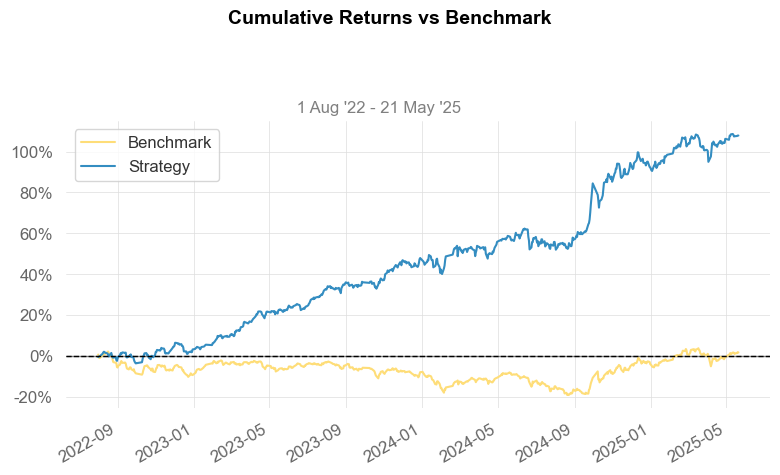

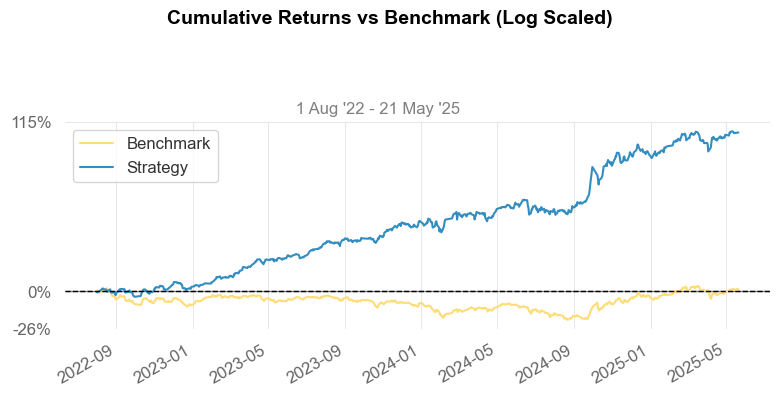

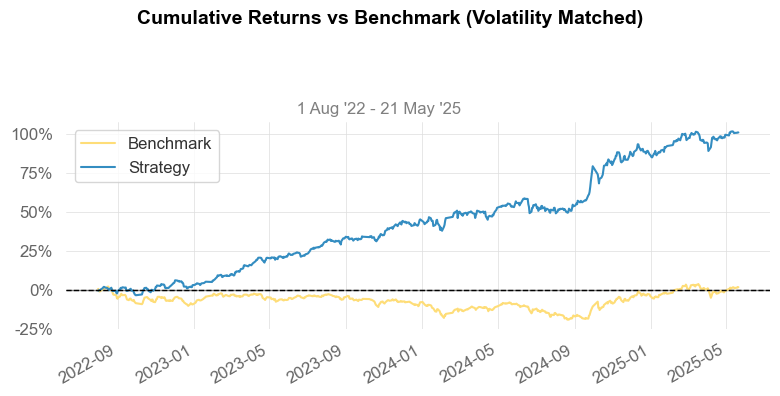

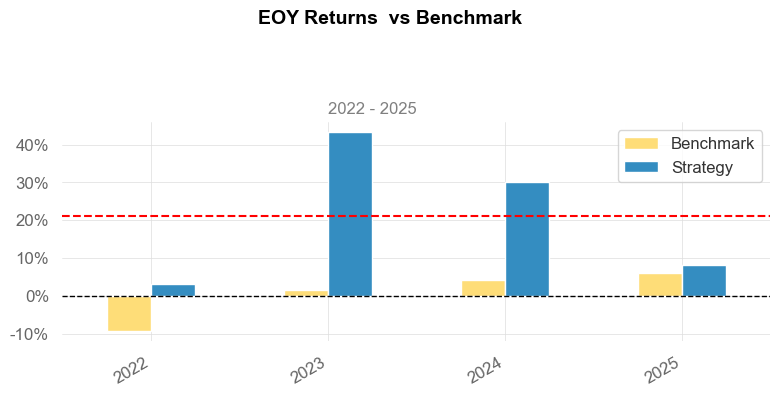

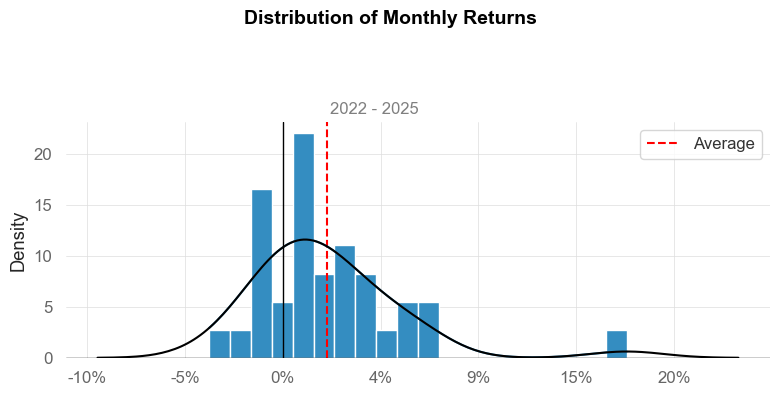

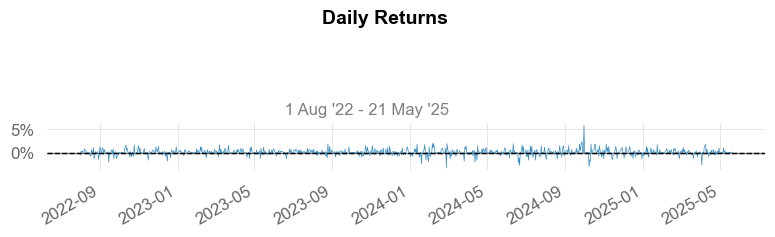

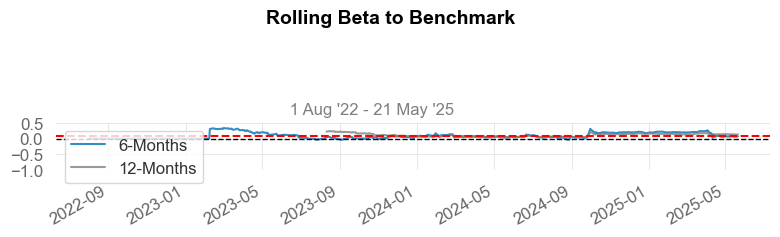

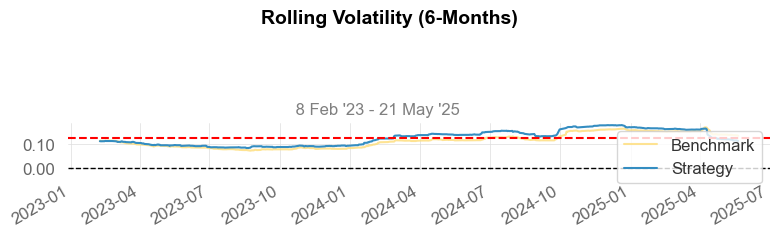

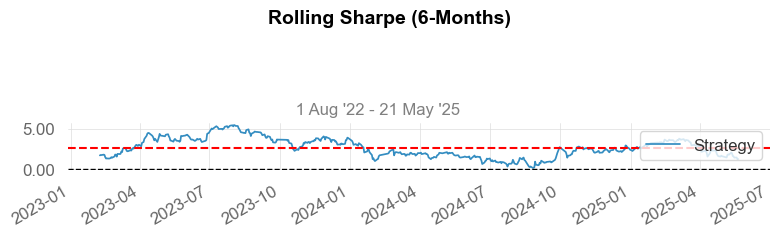

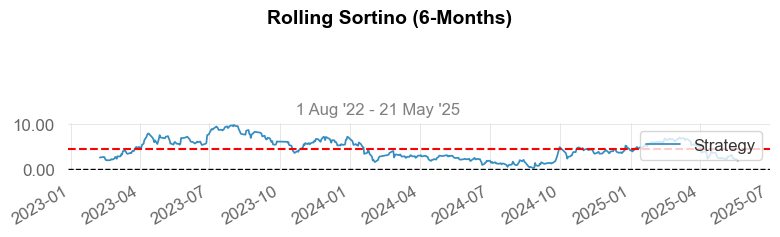

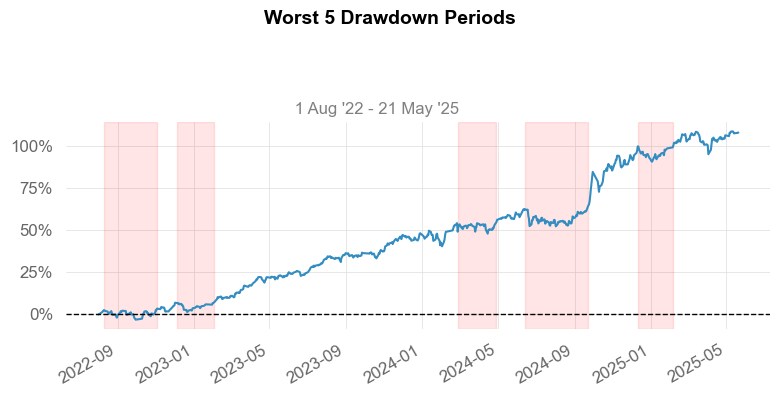

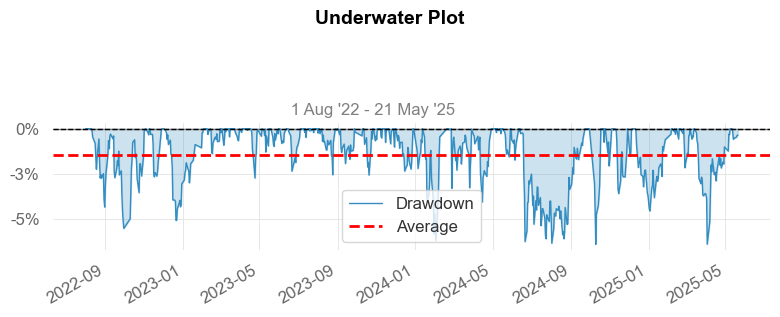

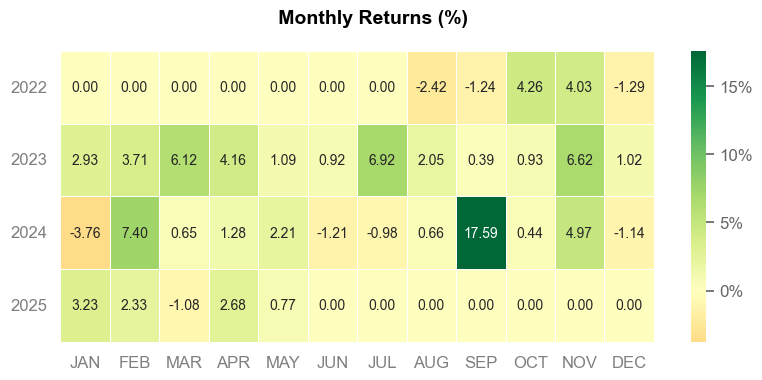

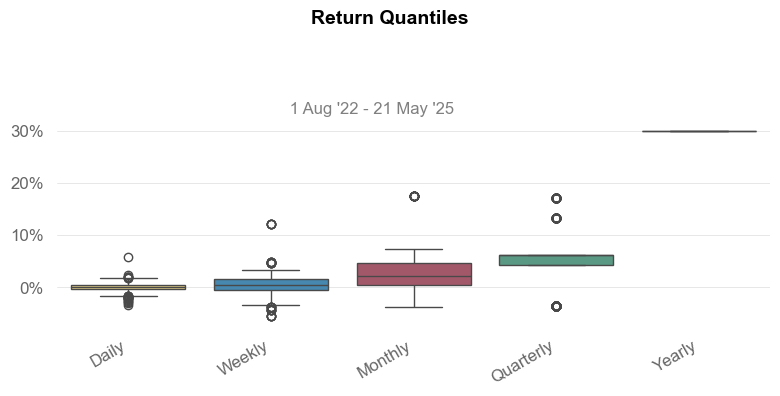

--- Report Generation Attempt Complete ---


In [45]:
# --- Code to Generate the Report (run in a new cell after the search) ---

# <<< USER INPUT: Look at the results_df displayed above and enter the index number of the desired row >>>
# For example, if the best result is at index 0 of results_df:
selected_combination_row_index_from_results_df = 0  # <--- CHANGE THIS VALUE (it's the DataFrame index, not necessarily sequential if you sorted)

if 'results_df' not in locals() or results_df.empty:
    print("Error: 'results_df' not found or is empty. Run the parameter search cell first.")
elif 'df_filtered' not in locals():
     print("Error: 'df_filtered' (the base filtered data) not found. Run the parameter search cell first.")
elif 'df_index' not in locals():
     print("Error: 'df_index' (the base index data) not found. Run the parameter search cell first.")
elif 'CONFIG' not in locals():
     print("Error: 'CONFIG' not found. Run the parameter search cell first.")
else:
    try:
        # Extract the specific weights from the chosen row in results_df
        # Ensure the index exists in results_df
        if selected_combination_row_index_from_results_df not in results_df.index:
            print(f"Error: Index {selected_combination_row_index_from_results_df} not found in results_df. Valid indices are: {results_df.index.tolist()}")
        else:
            factor_weight_columns_for_report = list(CONFIG['factor_weights_search'].keys())
            # Use .loc to access row by its index label
            weights_dict_for_report = results_df.loc[selected_combination_row_index_from_results_df, factor_weight_columns_for_report].to_dict()

            print(f"Generating report for combination with weights: {weights_dict_for_report}")
            
            # Call the helper function
            # df_filtered is the result of Step 2 filtering (done once)
            # df_index is the result of Step 1 loading (done once)
            # CONFIG is the main configuration dictionary
            generate_report_for_combination(
                factor_weights_dict=weights_dict_for_report,
                df_filtered_base=df_filtered.copy(), # Pass a copy to be safe
                index_df_base=df_index.copy(),       # Pass a copy
                config_dict=CONFIG
            )
    except KeyError as e:
        print(f"KeyError accessing results_df: {e}. Ensure 'selected_combination_row_index_from_results_df' is a valid index in results_df.")
        print(f"Selected index was: {selected_combination_row_index_from_results_df}")
        print(f"results_df indices are: {results_df.index}")
    except Exception as e:
        print(f"An unexpected error occurred during report generation: {e}")


Testing qs.plots.monthly_heatmap...


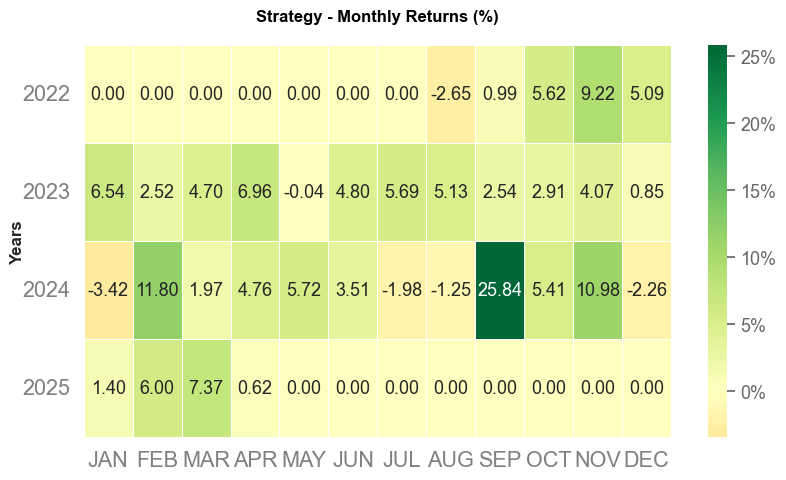

qs.plots.monthly_heatmap SUCCESS (check plot output)


In [7]:
# In a new cell
if 'net_returns' in locals() and net_returns is not None:
    try:
        print("\nTesting qs.plots.monthly_heatmap...")
        qs.plots.monthly_heatmap(net_returns, show=True) # show=True attempts to display
        print(f"qs.plots.monthly_heatmap SUCCESS (check plot output)")
    except Exception as e:
        print(f"qs.plots.monthly_heatmap FAILED: {e}")
else:
    print("net_returns not found.")